In [ ]:
!git clone https://github.com/nateraw/huggingface-vit-finetune.git
# !git clone https://github.com/chengyangfu/pytorch-vgg-cifar10.git
!pip install adversarial-robustness-toolbox
# !pip install timm

Cloning into 'huggingface-vit-finetune'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 24 (delta 10), reused 19 (delta 6), pack-reused 0
Unpacking objects: 100% (24/24), done.
     |████████████████████████████████| 962kB 15.3MB/s 
     |████████████████████████████████| 3.2MB 17.6MB/s 
     |████████████████████████████████| 21.6MB 1.5MB/s 
     |████████████████████████████████| 235kB 57.9MB/s 
     |████████████████████████████████| 6.8MB 27.0MB/s 
     |████████████████████████████████| 25.3MB 134kB/s 
     |████████████████████████████████| 747kB 48.8MB/s 
  Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-

In [ ]:
%cd huggingface-vit-finetune/
!pip install -r requirements.txt
!pip install git+https://github.com/huggingface/transformers.git@master --upgrade
# !python run.py

/content/huggingface-vit-finetune
     |████████████████████████████████| 839kB 13.1MB/s 
     |████████████████████████████████| 112kB 31.1MB/s 
     |████████████████████████████████| 184kB 29.4MB/s 
     |████████████████████████████████| 829kB 46.9MB/s 
     |████████████████████████████████| 276kB 22.6MB/s 
     |████████████████████████████████| 1.3MB 54.8MB/s 
     |████████████████████████████████| 143kB 60.8MB/s 
     |████████████████████████████████| 296kB 59.5MB/s 
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=23b14748f75f4603c53454701a3303f78c0738107d1535eb5ea6fda90b659890
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44620 sha256=a9f851505edb039e222eb1083a8ef49b0247725147096ce6a9b07cb1b2668f5d
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b2510

In [ ]:
# import timm
# from timm.data import resolve_data_config
# from timm.data.transforms_factory import create_transform

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import art
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescentPyTorch
from art.estimators.classification import PyTorchClassifier

import urllib
from PIL import Image

# For 98% model
from transformers import ViTFeatureExtractor, ViTForImageClassification
import requests

from torch.utils.data import DataLoader

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
    #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

cifar_trainloader = torch.utils.data.DataLoader(cifar_trainset, batch_size=64,
                                          shuffle=True, num_workers=2)
cifar_testloader = torch.utils.data.DataLoader(cifar_testset, batch_size=64,
                                         shuffle=False, num_workers=2)

cifar_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
]



Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Files already downloaded and verified


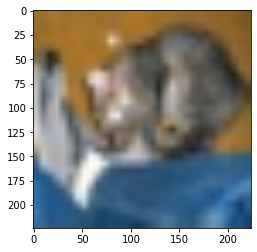

In [ ]:
transform = transforms.Compose(
    [
     transforms.Resize((224, 224)),
     transforms.ToTensor(),
    #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

cifar_testset_ut = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(cifar_testset_ut, batch_size=1)

# cifar_testset_ut[0][0].numpy()
plt.imshow(np.transpose(cifar_testset_ut[0][0].numpy(), (1, 2, 0)))

In [ ]:
url = 'https://www.cs.toronto.edu/~kriz/cifar-10-sample/dog10.png'
image = Image.open(requests.get(url, stream=True).raw)
feature_extractor = ViTFeatureExtractor.from_pretrained('nateraw/vit-base-patch16-224-cifar10')
model = ViTForImageClassification.from_pretrained('nateraw/vit-base-patch16-224-cifar10')
inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
preds = outputs.logits.argmax(dim=1)

classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
]
classes[preds[0]]

'dog'

In [ ]:
model = ViTForImageClassification.from_pretrained('nateraw/vit-base-patch16-224-cifar10', return_dict=False)
model.to(device)
# model.config

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_fea

In [ ]:
model = nn.Sequential(
    model,
    nn.Identity()
)
model
torch.save(model.state_dict(), "./pre_vit16_224_cifar10_98")

In [ ]:
!pip install timm

import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

     |████████████████████████████████| 296kB 10.4MB/s 


In [ ]:
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=10)
model.load_state_dict(torch.load("./pre_vit16_224_cifar10_98"))
model.to(device)

RuntimeError: ignored

In [ ]:
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (

In [ ]:
# Evaluation
correct = 0
total = 0
with torch.no_grad():
  for inputs, labels in cifar_testloader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    # print(outputs)
    # _, predicted = torch.max(outputs.logits, 1)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on %d cifar-10 test images: %d %%' % (
    total,
    100 * correct / total))

TypeError: ignored

In [ ]:
def pgd_attack(model, images, labels, eps=0.03, alpha=0.01, iters=20) :
    images = images.to(device)
    labels = labels.to(device)
    loss = nn.CrossEntropyLoss()
        
    ori_images = images.data
        
    for i in range(iters) :    
        images.requires_grad = True
        outputs = model(images)[0]

        model.zero_grad()
        cost = loss(outputs, labels).to(device)
        cost.backward()

        adv_images = images + alpha*images.grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()
            
    return images

In [ ]:
torch.cuda.empty_cache()

In [ ]:
correct = 0
total = 0

for i, (images, labels) in enumerate(cifar_testloader, 0):
  if i <= 1:
    print("iter: ", i)
    images = pgd_attack(model, images, labels)
    print(images)
    labels = labels.to(device)
    outputs = model(images)[0]
    
    _, pre = torch.max(outputs.data, 1)

    total += 1
    correct += (pre == labels).sum()
    
print('Accuracy of test text: %f %%' % (100 * float(correct) / total))

RuntimeError: ignored

In [ ]:
plt.imshow(np.transpose(test_x_adv_1[0], (1, 2, 0))) 
title_str =  "predicted as " + cifar_classes[np.argmax(predictions[0])] + \
      ", actual: " + cifar_classes[cifar_test_y[0]]
plt.title(title_str)

In [ ]:
plt.imshow(np.transpose(test_x_adv_1[10], (1, 2, 0))) 
title_str =  "predicted as " + cifar_classes[np.argmax(predictions[10])] + \
      ", actual: " + cifar_classes[cifar_test_y[10]]
plt.title(title_str)

In [ ]:
plt.imshow(np.transpose(test_x_adv_1[20], (1, 2, 0))) 
title_str =  "predicted as " + cifar_classes[np.argmax(predictions[20])] + \
      ", actual: " + cifar_classes[cifar_test_y[20]]
plt.title(title_str)

In [ ]:
plt.imshow(np.transpose(test_x_adv_1[50], (1, 2, 0))) 
title_str =  "predicted as " + cifar_classes[np.argmax(predictions[50])] + \
      ", actual: " + cifar_classes[cifar_test_y[50]]
plt.title(title_str)

In [ ]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.0005)  # 0.001 > 0.005 > 0.0003

classifier = PyTorchClassifier(
    model=model,
    # clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 224, 224),
    nb_classes=10,
)

# set up PGD-20 attack
eps = 0.03
attack = ProjectedGradientDescentPyTorch(
        estimator=classifier,
        norm="inf",
        eps=eps,
        targeted=False,
        eps_step=0.05,
        max_iter=20
)

In [ ]:
test_loader = DataLoader(cifar_testset, batch_size=len(cifar_testset))
cifar_test_x = next(iter(test_loader))[0].numpy()
cifar_test_y = next(iter(test_loader))[1].numpy()

In [ ]:
test_x_adv_1 = attack.generate(x=cifar_test_x[0:1000]) # takes around 7GB GPU
predictions = classifier.predict(test_x_adv_1)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(cifar_test_y[0:1000])) / len(cifar_test_y[0:1000])
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

AttributeError: ignored